In [21]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy import stats
from statistics import mode
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf

from skimage.transform import downscale_local_mean #For binning
from skimage.filters import threshold_otsu, threshold_local

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

from PIL import Image

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

In [11]:
def show_raw_images(row, ax, i, frame_key):
    plt.gray()
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") -->", fontsize=10)
    ax.imshow(image) #cmap = 'gray'
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_image_histograms(row, ax, i, frame_key):
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        plot = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
        ax.imshow(plot, cmap = 'gray')
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        #ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
        ax.hist(raw_image.ravel(), bins="auto")
    #ax.axis('off')
    plt.tight_layout(pad=.2)

In [13]:
directory = "Z"
exp = "10-15-22_s2_theBigOne2"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_saveto = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\histogram image analysis\\" #bottom_row_t01\\

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 54 files
 0 	 row1_t1.tif
 1 	 row1_t2.tif
 2 	 row1_t3.tif
 3 	 row1_t4.tif
 4 	 row1_t5.tif
 5 	 row1_t6.tif
 6 	 row1_t7.tif
 7 	 row1_t8.tif
 8 	 row1_t9.tif
 9 	 row2_t1.tif
 10 	 row2_t2.tif
 11 	 row2_t3.tif
 12 	 row2_t4.tif
 13 	 row2_t5.tif
 14 	 row2_t6.tif
 15 	 row2_t7.tif
 16 	 row2_t8.tif
 17 	 row2_t9.tif
 18 	 row3_t1.tif
 19 	 row3_t2.tif
 20 	 row3_t3.tif
 21 	 row3_t4.tif
 22 	 row3_t5.tif
 23 	 row3_t6.tif
 24 	 row3_t7.tif
 25 	 row3_t8.tif
 26 	 row3_t9.tif
 27 	 row4_t1.tif
 28 	 row4_t2.tif
 29 	 row4_t3.tif
 30 	 row4_t4.tif
 31 	 row4_t5.tif
 32 	 row4_t6.tif
 33 	 row4_t7.tif
 34 	 row4_t8.tif
 35 	 row4_t9.tif
 36 	 row5_t1.tif
 37 	 row5_t2.tif
 38 	 row5_t3.tif
 39 	 row5_t4.tif
 40 	 row5_t5.tif
 41 	 row5_t6.tif
 42 	 row5_t7.tif
 43 	 row5_t8.tif
 44 	 row5_t9.tif
 45 	 row6_t1.tif
 46 	 row6_t2.tif
 47 	 row6_t3.tif
 48 	 row6_t4.tif
 49 	 row6_t5.tif
 50 	 row6_t6.tif
 51 	 row6_t7.tif
 52 	 row6_t8.tif
 53 	 row6_t9.tif


In [26]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

total_rows = 6

time_array = [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]
#s1 [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]
#s2 [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.364 # 4*0.091 = 0.364
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

fig_size = 10,10/1.618
###  size of output figures
font_size = 16
### font size
dpi_num = 600
### image quality level (recommendation: 600)

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/total_rows)
print("total number of time points: "+ str(arr_length))
if arr_length % 2 == 0:
    num_rows = int(arr_length/2)
else:
    num_rows = int((arr_length+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

tiff file dimensions: (5, 1440, 1920)
total number of time points: 9
(for image previews) number of rows = 5


condition: 1-3 kA-WT


<IPython.core.display.Javascript object>


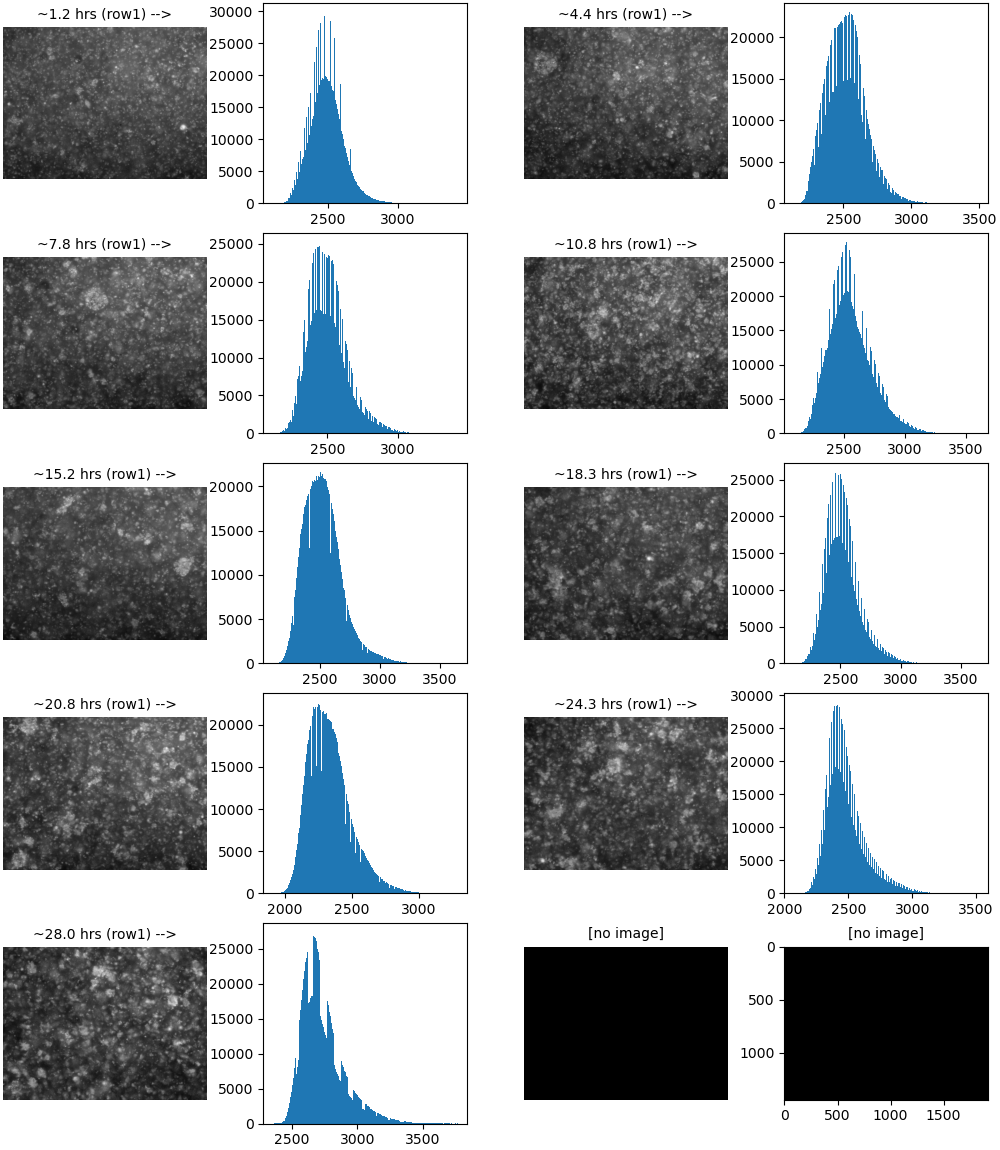

[1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]


In [14]:
frame_key = 0
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
print("condition: "+condition)

row = 1
### choose which set of tiff files should be analyzed, row1, row2 or row3

fig_height = num_rows*2.3
time_array.append(0)
i = 0
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_raw_images(row, ax, i, frame_key)
    else:
        show_image_histograms(row, ax, i, frame_key)
        i = i + 1 
plt.show()
time_array.remove(0)
print(time_array)
details = " (row"+str(row)+")"
### option to save this figure (uncomment below)
fig.savefig(data_saveto+"histograms for "+condition+details+".jpg", dpi=dpi_num)

In [36]:
image = tiff_file.imread(files[9],key=[0])
print(np.median(image))
print(np.mean(image))
print(np.std(image))

return_which = " "

def analyze_image(image, return_which):
    median_val = np.median(image)
    mean_val = np.mean(image)
    std_dev_val = np.std(image)
    if return_which == "mean":
        return mean_val
    if return_which == "median":
        return median_val
    if return_which == "std_dev":
        return std_dev_val
    
analyze_image(image, "mean")

2438.0
2446.1445757378474
128.33234407135888


2446.1445757378474

In [64]:
### "key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed, tiff_file.imread(files[i],key=[key]
key = 3
condition = frame_names[key]
print(condition)

### cmap dictates the color gradient used in plots; options: 'Reds' 'Blues' 'Greens' 'Greys' 'Purples' ...
cmap = matplotlib.cm.get_cmap('Greys')  

### Set up empty arrays to save results in
all_means = np.zeros((total_rows,arr_length))
avg_means = np.empty(arr_length)
stderror_means = np.empty(arr_length)

all_medians = np.zeros((total_rows,arr_length))
avg_medians = np.empty(arr_length)
stderror_medians = np.empty(arr_length)

all_std_dev = np.zeros((total_rows,arr_length))
avg_std_dev = np.empty(arr_length)
stderror_std_dev = np.empty(arr_length)

### cmap_num is used the when plotting each curve to adjust the color gradient according to the total number of time points
### e.g. for i in range(arr_length): the color of each curve is determined by c=cmap(0.9-(i/cmap_num))
cmap_num = (arr_length*2) - 2

for i in range(arr_length):    
### "im_corr" is the actual SIA function which filters, bins, and fourier transforms tiff images to generate SIA curves
    all_means[0,i] = analyze_image(tiff_file.imread(files[i],key=[key]), "mean")
    all_means[1,i] = analyze_image(tiff_file.imread(files[i+arr_length],key=[key]), "mean")
    all_means[2,i] = analyze_image(tiff_file.imread(files[i+(arr_length*2)],key=[key]), "mean")
    all_means[3,i] = analyze_image(tiff_file.imread(files[i+(arr_length*3)],key=[key]), "mean")
    all_means[4,i] = analyze_image(tiff_file.imread(files[i+(arr_length*4)],key=[key]), "mean")
    all_means[5,i] = analyze_image(tiff_file.imread(files[i+(arr_length*5)],key=[key]), "mean")
    
    all_medians[0,i] = analyze_image(tiff_file.imread(files[i],key=[key]), "median")
    all_medians[1,i] = analyze_image(tiff_file.imread(files[i+arr_length],key=[key]), "median")
    all_medians[2,i] = analyze_image(tiff_file.imread(files[i+(arr_length*2)],key=[key]), "median")
    all_medians[3,i] = analyze_image(tiff_file.imread(files[i+(arr_length*3)],key=[key]), "median")
    all_medians[4,i] = analyze_image(tiff_file.imread(files[i+(arr_length*4)],key=[key]), "median")
    all_medians[5,i] = analyze_image(tiff_file.imread(files[i+(arr_length*5)],key=[key]), "median")
    
    all_std_dev[0,i] = analyze_image(tiff_file.imread(files[i],key=[key]), "std_dev")
    all_std_dev[1,i] = analyze_image(tiff_file.imread(files[i+arr_length],key=[key]), "std_dev")
    all_std_dev[2,i] = analyze_image(tiff_file.imread(files[i+(arr_length*2)],key=[key]), "std_dev")
    all_std_dev[3,i] = analyze_image(tiff_file.imread(files[i+(arr_length*3)],key=[key]), "std_dev")
    all_std_dev[4,i] = analyze_image(tiff_file.imread(files[i+(arr_length*4)],key=[key]), "std_dev")
    all_std_dev[5,i] = analyze_image(tiff_file.imread(files[i+(arr_length*5)],key=[key]), "std_dev")
    
### corresponding x-values calculated according to the length of a SIA curve array (r1_corr_rad_array[0]) and pixel size
avg_means = all_means.mean(axis=0)
stderror_means = all_means.std(axis=0)/np.sqrt(total_rows)

avg_medians = all_medians.mean(axis=0)
stderror_medians = all_medians.std(axis=0)/np.sqrt(total_rows)

avg_std_dev = all_std_dev.mean(axis=0)
stderror_std_dev = all_std_dev.std(axis=0)/np.sqrt(total_rows)
print(avg_means)
print(avg_medians)
print(avg_std_dev)

AE KaiC
[2188.6152829  2175.34465585 2173.68644109 2224.10777543 2210.09908878
 2131.72715706 2107.86531256 2279.48835835 2255.22823544]
[2181.66666667 2167.16666667 2164.66666667 2214.         2200.5
 2122.         2097.66666667 2262.66666667 2239.        ]
[110.01093198 116.23645966 121.71477131 133.70965219 125.2604934
 123.55721748 126.13683243 112.64619901 108.68495795]


<IPython.core.display.Javascript object>


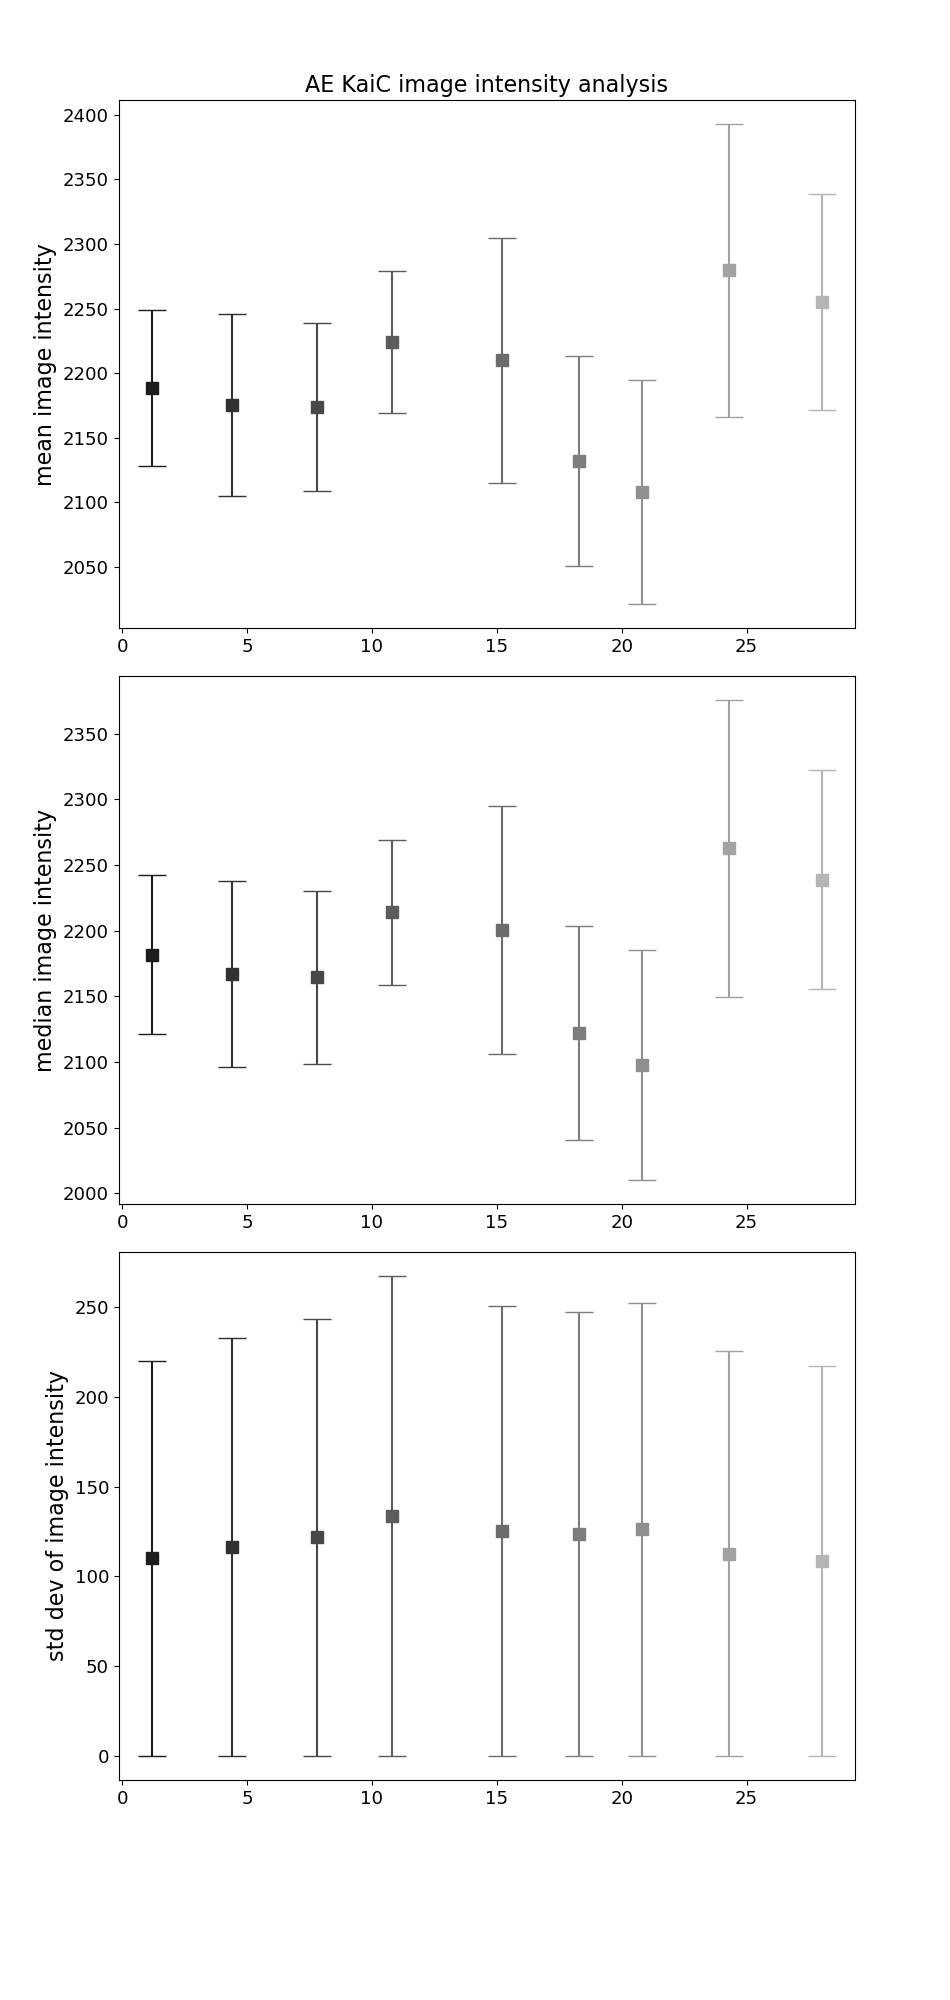

In [65]:
### plot average values and std. error for L1 correlation lengths
fig = plt.figure(figsize=(9.5, 20))
gs = fig.add_gridspec(3, top=0.95, hspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
#fig, axs = plt.subplots(3, figsize=(fig_size))
markerSize = 8
title = condition +" image intensity analysis"

for i in range(arr_length):
    axs[0].set_title(title, fontsize= (font_size))
    axs[0].set( ylabel='mean image intensity')
    #axs[0].set_ylim(0, 400)
    axs[0].plot(time_array[i], avg_means[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    axs[0].errorbar(time_array[i], avg_means[i], yerr = stderror_means[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[1].set( ylabel='median image intensity')
    #axs[1].set_ylim(0, 60)
    axs[1].plot(time_array[i], avg_medians[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    axs[1].errorbar(time_array[i], avg_medians[i], yerr = stderror_medians[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[2].set( ylabel='std dev of image intensity')
    #axs[2].set_ylim(0, 60)
    axs[2].plot(time_array[i], avg_std_dev[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    axs[2].errorbar(time_array[i], avg_std_dev[i], yerr = avg_std_dev[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=(font_size-3))
    ax.xaxis.get_label().set_fontsize(font_size)
    ax.yaxis.get_label().set_fontsize(font_size)

#plt.subplot_tool()
plt.show()
fig.savefig(data_saveto+title+".jpg", dpi=dpi_num)